***
<left>
    <img style="float: left;" src="module3_heading.jpeg" width="800"></img>
</left>

<br/><br/>
<br/><br/>

# Measuring the performance of Models


Machine Learning models usually do not come with an estimate of its performance. Since, estimating the performance of a model is essential, we use different flavors of a method called **Cross Validation**. The essential idea of the method is that we estimate the performance of the model in terms of evaluations called **metrics** on a sample of data, which has not been used in optimizing the model so far. Thus, we will discuss two important concepts : `metrics` which should be chosen carefully for the problem in question, and a few flavours of `Cross Validation`




# Measuring Model Performance : Metrics


Measuring the performance of your model, whether it is a classification or regression model can require considerable care, especially for classification. Here we will go through a few basic methods.

## Regression

There are several ways to measure regression error. When it comes to linear regression or ordinary least squares regression we are usually working with a metric that is called mean squared error. If the error has mean zero then the mean squared error is just the variance of the error.

### Mean Squared Error

Let us say that we have a set of features $X$, a target variable $y$ and our goal is to build a function that maps $X$ to $y$ using a regression model. We call this regression model $f$ and we define $\hat y = f(X)$, i.e. $\hat y$ is our estimate of $y$. This allows us to measure the error between the estimated value and the true value. More precisely, if we have $n$ data points, we have $\{X_1,\ldots, X_n\}$ as our input data and $\{y_1,\ldots,y_n\}$ as our target, then $\{\hat y_1, \ldots, \hat y_n\}$ are our estimates of $y$ coming from the regression model, so we can compute the mean squared error as already introduced in the _Supervised Learning_ module

$$\text{MSE}=\frac{1}{n} \sum_{i=1}^n \left|y_i - \hat y_i\right|^2 \quad .$$

### Root Mean Squared Error

Taking the root of the MSE yields

$$\text{RMSE}=\sqrt{ \frac{1}{n} \sum_{i=1}^n \left|y_i - \hat y_i\right|^2 } \quad $$

whose only difference to MSE is that it has the same units as the target variable. However, do not confuse RMSE with an "average error": the closest thing to an "average error" is the mean absolute error (see below).

### Coefficient of Determination $R^2$

The MSE is a value that depends on the scale of the labels, but often you might want a normalized value. This is where the **coefficient of determination** comes in, and it is defined as follows: we start with the definition of the variance of the target variable $y$

$$\sigma_y^2 = \frac{1}{n} \sum_{i=1}^n \left|y_i - \bar y\right|^2, \quad \text{$\bar y$ is the average of $y$}$$

then we define the coefficient of determination as

$$R^2 = 1- \frac{\text{MSE}}{\sigma_y^2} \quad.$$

Ideally you would want to see $R^2$ in the range between 0 and 1, which will almost always be the case when you measure your training performance. The testing performance on the other hand can actually be negative, this means that the model we are evaluating is doing worse than guessing the average. We usually call this an overlearning or overfitting problem. A good heuristic way of interpreting the $R^2$ metric is as the _fraction of the variance that is explained by the model_.

#### An example of $R^2$

Let us compute an example MSE based on the Cars dataset that we used previously when working with supervised learning. The idea is to build a regression model between the size of the engine and the fuel consumption in gallons per mile (GPM).

In [1]:
import pandas as pd
cars = pd.read_csv('../../Data/cars.csv')
cars.head(2)

,Model,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin
0,chevrolet chevelle malibu,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0
1,buick skylark 320,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0


In [2]:
# Convert Miles per Gallon to Gallons per Mile
cars['GPM'] = 1/cars['MPG']
cars = cars.dropna()

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
lin_reg = LinearRegression()
X = cars[['Displacement']]
y = cars['GPM']
lin_reg.fit(X,y)

LinearRegression()

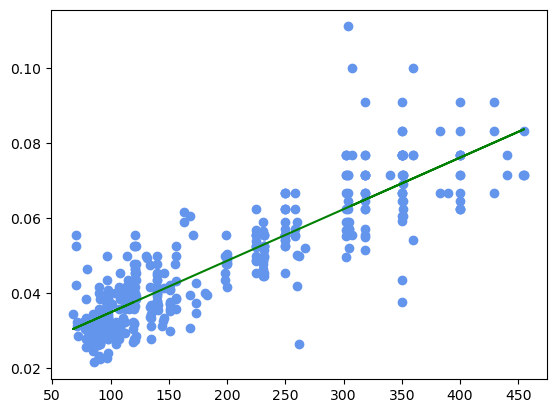

In [5]:
import matplotlib.pyplot as plt
plt.scatter(X['Displacement'],y,color='cornflowerblue')
plt.plot(X['Displacement'],lin_reg.predict(X),color='green')
plt.show()

The green straight line above is the linear regression model fitted to the data. Now we would like to know its $R^2$. In `sklearn` all regression models have a score function that can be used to evaluate the model, in most cases this score is $R^2$ so lets use it and see what we get:

In [6]:
lin_reg.score(X,y)

0.7500424018659729

Let us also go through all the steps in the calculation of $R^2$. We begin by computing the estimated $y$, i.e. $\hat y$:

In [7]:
import numpy as np

hat_y = lin_reg.predict(X)
# The average y i.e. \bar{y}
bar_y = np.mean(y)
# The mean square error defined above
MSE = np.mean((y-hat_y)**2)
# The variance of y defined above
sigma2 = np.mean((y-bar_y)**2)
# The R^2 value defined above based on MSE and sigma2
R2 = 1 - MSE/sigma2
R2

0.7500424018659729

Unsurprisingly we did get the same value. Now you know how to compute it, both by hand and by using the built-in `score` function.

### Mean Absolute Error

A very similar error metric is the Mean Absolute Error (MAE) which looks similar to the MSE, but where we take the absolute value instead of the square, i.e. 

$$\frac{1}{n} \sum_{i=1}^n \left|y_i - \hat y_i\right| \quad.$$

Mathematically MAE is more cumbersome to work with, and if used as a cost function it generally leads to slower convergence. However, it is less sensitive to large outliers since the error increases linearly with the distance from $y$. MSE, on the other hand, puts more emphasis on large errors. This implies that models based on MSE are less stable than models based on MAE. That said, we could also train a model based on MSE and evaluate it on MAE. MAE might make more sense to use if, for instance, the error incurs a cost if you would apply the model in the real world. In such situations the expected win/loss can be nicer to evaluate with MAE.

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [9]:
mean_absolute_error(lin_reg.predict(X),y)

0.0060815870209631456

In [10]:
mean_squared_error(lin_reg.predict(X),y)

6.902943892786819e-05

## Classification

When measuring the performance of a classification model there are a number of options to choose from. The choice is somewhat personal in what you prefer, but often there are business reasons for which metric you should use for your project. In this part we will go through the most common ways to measure classification performance, addressing the pros and cons of each. 

### Accuracy

The first metric is the naive accuracy metric that we already saw in the _Supervised learning_ module, i.e. it just measures the percentage of correct guesses. This might sound like a good idea at first, but we will go through some examples to highlight that it can be quite misleading. 

#### Definition

Given a set of true labels $\{y_i, i=1,\ldots,n\}$ and the guessed labels $\{\hat y_i, i=1,\ldots,n\}$, then we define the accuracy as

$$\text{Accuracy}(y,\hat y) = \frac{1}{n} \sum_{i=1}^n 1_{\left\{y_i = \hat y_i\right\}}$$

where the function $1_{\{a = b\}}$ is $1$ if $a=b$, and $0$ otherwise. This is a very simple metric to define and compute, and it is easy to see that if we get an accuracy of $1.0$ we have a perfect classifier. 

#### Caveats

Most of the problems with classification metrics start to become apparent when we have a class imbalance. Next we will be using a 90/10 split to illustrate the problem with our metric.

In [11]:
# For simplicity we will construct a classification dataset with two features and two classes
from sklearn.datasets import make_classification
X_data, y_data = make_classification(n_samples=2000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=10)

In [12]:
from imblearn.datasets import make_imbalance

We now utilize `make_imbalance` to create an imbalanced dataset from the balanced dataset above.

In [13]:
X_data_imb, y_data_imb = make_imbalance(X_data,y_data, sampling_strategy={0:900,1:100},random_state=10)
X_data_imb = X_data_imb+20

You might be wondering why we added 20 to the features above. For imbalanced datasets, logistic regression will behave poorly if we don't have zero mean data, so we are purposefully making our classifier worse than it should be.

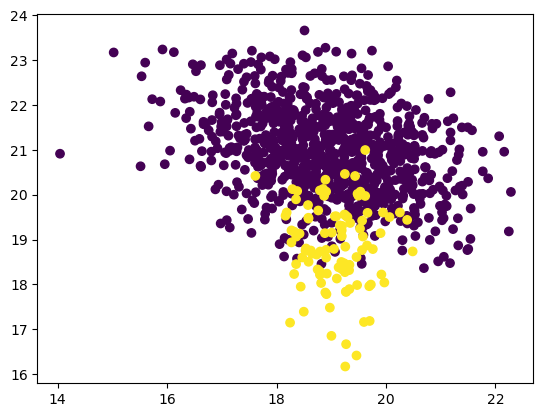

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(X_data_imb[:,0],X_data_imb[:,1],c=y_data_imb)
plt.show()

In [15]:
# Let us train a logistic regression model on the above classification problem
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=10,solver='liblinear')
lr.fit(X_data_imb, y_data_imb)

LogisticRegression(random_state=10, solver='liblinear')

In [16]:
acc = np.sum(y_data_imb == lr.predict(X_data_imb))/len(y_data_imb)
acc

0.901

OK, we have a great result, our accuracy is ~0.9! But what does this actually mean when we have this imbalanced dataset?
In fact, we could construct a (cheating) classifier that will guess class 0 all the time, and we would still get an accuracy of 0.9. Let us see how that looks.

In [17]:
acc_naive = np.sum(y_data_imb == 0)/len(y_data_imb)
acc_naive

0.9

Now we start to become wary of our previous result, i.e. around 0.9... what does it actually mean?
Let us dig deeper and look at the within-class accuracy:

In [18]:
# Out of class 0 how many times did we actually guess a 0?
X_data_imb_0 = X_data_imb[y_data_imb == 0]
acc_0 = np.sum(0 == lr.predict(X_data_imb_0))/len(X_data_imb_0)
acc_0

0.9888888888888889

In [19]:
# Now we come to the crucial question, how well did we do on class 1?
X_data_imb_1 = X_data_imb[y_data_imb == 1]
acc_1 = np.sum(1 == lr.predict(X_data_imb_1))/len(X_data_imb_1)
acc_1

0.11

Wow! That is bad, we thought we had a good classifier but it actually guesses correct in the 1 class only 11% of the time.

#### Conclusion

Whenever you are using accuracy, make sure you understand what is actually your class balance and what it means for you. Sometimes we have a perfect split of two classes, i.e. 50/50 split, and then accuracy is a great metric.

### Confusion Matrix

Let us consider a binary class, say, class 0 or 1 as in the example above.  Let us also refer to "class 0" as negative, and "class 1" as positive. 

There are two point of views on our data. In reality, each data point can be either positive or negative; this is the _ground truth_.  Then, there is the model's point of view: each data point can be classified as either positive or negative. The two point of views will rarely coincide in practice (if they did, we would have a perfect classifier).


<img src="true_false_positives2.png"> 

To understand if a data point is correctly guessed, we start from the model's point of view and define:

 - true positives: positive according to the model;  correct guess (positive also in the ground truth)
 - false positives: positive according to the model;  wrong guess (negative in the ground truth)
 - true negatives: negative according to the model;  correct guess (negative also in the ground truth)
 - false negatives: negative according to the model;  wrong guess (positive in the ground truth)



A confusion matrix lists the number of TP, FP, TN, FN in a square arrangement. It can be useful by itself, but more importantly it is the starting point to define a number of other metrics. For example, two metrics that are easy to define are the true positive rate (TPR) and the false positive rate (FPR):

$$\mathrm{TPR} = \frac{ \mathrm{TP} }{ \mathrm{TP}+\mathrm{FN} }$$

$$\mathrm{FPR} = \frac{ \mathrm{FP} }{ \mathrm{TN}+\mathrm{FP} }$$

They also have the names of Recall and Fall-out, respectively, and can be interpreted as the probability of detection, and the probability of false alarm.

### ROC and AUC

The Receiver Operating Characteristic curve and the corresponding Area Under the Receiver Operating Characteristic curve (AUC/AUCROC) is a classical way to measure classifier performance. The restriction is that it only works for binary classification, i.e. we only have two classes. It is more complicated than accuracy but also much more useful.

#### Definition

Whenever we have a classifier that internally gives a probability score of each point belonging to a class, as we saw with Logistic Regression, that score can be used to make other decisions about the final predicted class. Remember that our first way to make a prediction using logistic regression was to choose the class with the highest predicted probability; now we shift our mindset a bit and think of a threshold instead. Let us call this threshold $T \in [0,1]$ and make the item $X_i$ to be classified as label $1$ if $P(y=1|X_i) \geq T$, otherwise we put it as class $0$. If we vary the threshold $T$ between $0$ and $1$, then for each choice we get a particular set of False Positives and True Positives. If we plot the TPR and FPR on a curve, that curve is called the Receiver Operating Characteristic (ROC) and it looks like the following:

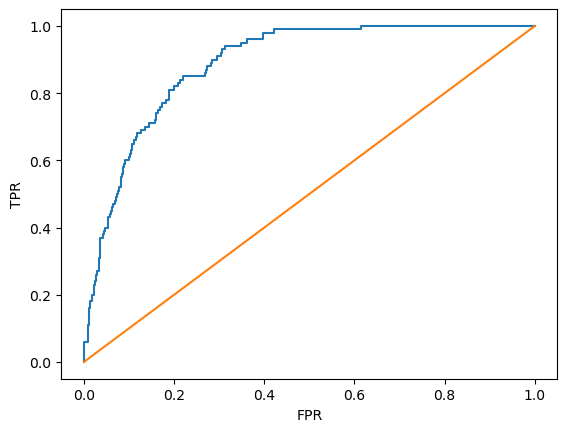

In [20]:
from sklearn.metrics import roc_curve

# The below code might need some explanation. 
# Since Logistic regression actually computes a probability
# under the hood, we can access it by calling predict_proba 
# instead of predict. Predict proba outputs as many
# probabilities as you have classes and we only want the probability 
# of class 1, therefore we slice the resulting array into a 
# one dimensional array with only the class 1 probabilities.

fpr, tpr, thresholds = roc_curve(y_data_imb,lr.predict_proba(X_data_imb)[:,1])
plt.plot(fpr,tpr)
plt.plot(fpr,fpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

As we see above the graph uses FPR = False Positive Rate and TPR = True Positive Rate.

The blue curve above is useful because if we are interested in a set value for TPR we can just look at the graph and figure out how much FPR we get from the classifier. The threshold to choose is the one that best suits your objectives. For instance, it could be that a false positive costs a lot and you don't gain that much from a true positive, then you would set the threshold so that you end up at the point on the graph that maximizes your profit. 

#### AUC, AUCROC

The graph above might be nice to look at and very useful when you want to select a threshold, but if you wish to obtain a score-value on the objective performance of your classifier we can look at the area under the curve (AUC, sometimes also AUCROC). A perfect classifier has AUC$=1.0$ (its theoretical maximum). A random guessing classifier instead has AUC=$0.5$, because for random guessing we expect FPR$=$TPR; the random classifier performance is the orange line plotted above. 

Going back to the classifier constructed above, let's calculate its AUC:

In [21]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_data_imb,lr.predict_proba(X_data_imb)[:,1])

0.8874

#### Caveats

We end up with an AUC of $\sim 0.89$. When working in the industry you will hear stuff like _"I got an AUC of 0.9 and that's pretty good"_. Well this is up for debate, as with accuracy it depends on the class balance. An AUC of 0.9 actually means that if I take one item from class 0 and one item from class 1 what is the probability that the classifier will correctly classify them? Inherent in this argument is that we are not taking "two random items", but one from the big class and one from the small class. This implies that AUC doesn't really tell you that much about the performance of two randomly taken items. For further reading, see [here](https://www.alexejgossmann.com/auc/) for instance.

#### Upshots

AUC is a very stable measurement and is very useful when performing cross-validation for instance. If we only want to pit two models against each other then AUC is a good choice and it is fairly easy to compute.

### Precision and Recall

When it comes to an
imbalanced dataset where you are interested in more in-depth knowledge about the performance of your classifier, then the recommended method is precision/recall. Precision/recall is a class-specific number and you can compute the precision and recall for each class. There is also a similar approach as with the ROC, i.e. that you can plot precision vs. recall on a curve by changing the threshold value.

Precision is defined as follows

$$\text{Precision} = \frac{\text{TP}}{\text{FP} + \text{TP}}$$

and it means: _out of the ones that the classifier says is positive, what fraction is actually positive?_

The other one of interest is the Recall, which is the same as the TPR defined above:

$$\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

and it means: _what fraction of the ones in the positive class did the classifier catch?_

Let us say that we want to find out who is sick and offer them a treatment. For this we train a predictive algorithm, where positive means that the person is sick. In this setting, precision means _"how many of those who the algorithm picks out as sick are actually sick"_. We can thus know how many unnecessary treatments we perform. Recall on the other hand means _"how many of the actually sick ones did the algorithm say were sick"_ , i.e. how many of the sick ones did we end up treating. It is quite obvious why this could be useful.

It is often important to also consider the recall of the opposite class: it is the recall that we would get if we switched the class definition. Its proper name is specificity:

$$\text{Specificity} = \frac{\text{TN}}{\text{TN} + \text{FP}}$$

and it means _"how many of the actually healthy ones did the algorithm say were healthy"_. This is useful because it helps keeping the costs down: we will have to do follow-ups exams on all our positives, and if we reduce the number of false positives, we also reduce the total cost.

A final note on imbalance: if you apply your model to a new dataset that has a different imbalance than that on which you trained/tested the model, you can expect recall and specificity to stay the same, while precision will change.

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_data_imb, lr.predict(X_data_imb)))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       900
           1       0.52      0.11      0.18       100

    accuracy                           0.90      1000
   macro avg       0.72      0.55      0.56      1000
weighted avg       0.87      0.90      0.87      1000



In the above results, class 0 has a good precision and recall, but guessing only 0 would give precision=0.9 and recall=1. The positive class is however a bit problematic, we only caught 11% of the sick persons. This model is not one you would use for screening a population.

#### Precision and Recall curve

As with the ROC curve we can construct something which is called a precision-recall curve, basically the idea is the same, i.e. we want to see precision and recall at different threshold values.

Again, as with the ROC, we will classify item $X_i$ as label $1$ if $P(y=1|X_i) \geq T$ otherwise we put it as class $0$. If we vary the threshold $T$ between $0$ and $1$, then we get a particular set of precision and recall for each choice of $T$. We can therefore plot the curve:

Average precision-recall score: 0.45


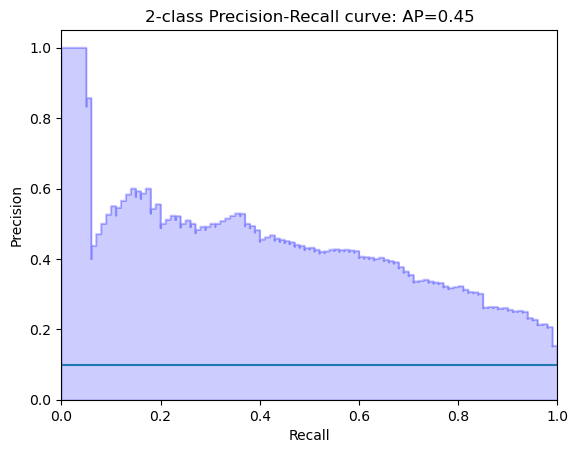

In [23]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_data_imb, lr.predict_proba(X_data_imb)[:,1])

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, thresholds = precision_recall_curve(y_data_imb,lr.predict_proba(X_data_imb)[:,1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

plt.plot([0.0,1.0],2*[1-acc_naive])

As we see in the curve above, if we want to catch all those that are sick (recall$\sim 1$), we need to accept a precision of 0.2: it means that for 8 out of 10 people the treatment (or at least a follow-up exam) is wasted. This is better but not much better than guessing that everybody is sick, in that case you would need to treat 9/10 people, this is what the horizontal line means.

#### Precision and Recall AUC
As with the ROC curve we can compute the area under the curve (AUC) as a summary statistic for the performance of the classifier.

In [24]:
from sklearn.metrics import auc
auc(recall,precision)

0.4442264121867036

#### Caveats

Precision and recall also work well when having multiple classes since you can compute the precision and recall for each class separately. However, it becomes problematic when doing model selection and cross validation, because we have to decide how to weigh the different scores between the different classes. Phrased in the correct way, precision and recall can be very natural to explain, but if the classification problem is a bit non-standard it can be hard to explain exactly what they actually mean. The AUC for precision/recall depends on the data imbalance, because in practice precision will always be above the random-guess performance line, and the position of that line depends on the imbalance. Thus, there is no objective value for a good AUC as there is in the AUCROC curve, and the same AUC for precision/recall means different things for different class balances.

When comparing precision/recall to ROC, the key point is probably to have a good understanding of the business case: what is our primary objective? (E.g. do we want to find sick people? Or faulty machines?) Do we have to satisfy any boundary condition? (E.g. can we afford to follow-up all our positives? Will any operator looking at our model, and tasked with a decision, take our predictions seriously if we have precision <50%?)  Reasoning about it early in a project, and discussing it with customers and stakeholders, is likely the best way to help your project succeed.


### F1-metric, macro vs. micro
Having precision and recall we can compute the $F_1$ score which is a weighted average (harmonic average) of the two, it is defined as

$${\displaystyle F_{1}=\left({\frac {\mathrm {recall} ^{-1}+\mathrm {precision} ^{-1}}{2}}\right)^{-1}} \quad .$$

This can be simplified as

$${\displaystyle F_{1}=2\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}} \quad .$$

This can be used as a metric that *balances* the precision and recall components. But when doing model evaluation we need one metric for all classes and this is where the $F_1$ macro and micro are introduced. Both of them are defined based on the confusion matrix of each class, and then are weighted together into one metric. $F_1$ macro and micro do the weighting a bit differently, but they are both useful for model evaluation.

First, we produce an average precision for each class. We have used two classes so far, but the extension is straightforward. In the following, $\text{TP}_i$ are the true positives for class $i$, and similarly for FN and FP.

$$P_{\text{micro}} = \frac{\text{TP}_1+\text{TP}_2}{\text{TP}_1+\text{TP}_2+\text{FP}_1+\text{FP}_2}$$

$$R_{\text{micro}} = \frac{\text{TP}_1+\text{TP}_2}{\text{TP}_1+\text{TP}_2+\text{FN}_1+\text{FN}_2}$$

Then we produce the micro $F_1$ as
$${\displaystyle F_{1,\text{micro}}=\left({\frac {R_{\text{micro}} ^{-1}+P_{\text{micro}} ^{-1}}{2}}\right)^{-1}}$$

The macro versions instead just average the precisions and recalls, separately, and then calculate $F_1$.  Here, $P_i$ and $R_i$ are the precision and recall for class $i$.



$$P_{\text{macro}} = \frac{\text{P}_1+\text{P}_2}{2}$$

$$R_{\text{macro}} = \frac{\text{R}_1+\text{R}_2}{2}$$

and then simply

$${\displaystyle F_{1,\text{macro}}=\left({\frac {R_{\text{macro}} ^{-1}+P_{\text{macro}} ^{-1}}{2}}\right)^{-1}}$$

We have already seen the $F_1$ score, namely in the `classification_report` above. To compute the different micro/macro metrics we can use the `precision_recall_fscore_support` from `sklearn.metrics`,

In [25]:
from sklearn.metrics import precision_recall_fscore_support
prfs_macro = precision_recall_fscore_support(y_data_imb, lr.predict(X_data_imb),average='macro')
print("Macro Precision: %.2f \t Macro Recall: %.2f \t Macro F1: %.2f" % prfs_macro[:-1])

Macro Precision: 0.72 	 Macro Recall: 0.55 	 Macro F1: 0.56


In [26]:
prfs_micro = precision_recall_fscore_support(y_data_imb, lr.predict(X_data_imb),average='micro')
print("Micro Precision: %.2f \t Micro Recall: %.2f \t Micro F1: %.2f" % prfs_micro[:-1])

Micro Precision: 0.90 	 Micro Recall: 0.90 	 Micro F1: 0.90


As we see above the macro average is more sensitive to a small class that performs badly, the micro average model is however much less sensitive to small classes.

## Measuring Model Performance : Practical procedures for metric evaluation

Now that we have gone through some of the common metrics, let us discuss how we usually 
use them. 

## Cross validation


#### Hold out cross validation

Because evaluating metrics on the data set used to train the model is likely to give incorrect (and over-optimistic) results if the model is overfit, we often use Hold out cross validation. This is the basic idea we have been following from Module 2 : (1) Split the data $\mathcal{D}$ randomly (taking care of constraints, e.g. remember the caveats for time series data !) into two pieces a **training set** $\mathcal{D}_{\rm{train}}$ and a Hold Out set $\mathcal{D}_\rm{HO}$. Developing a mathematical model on $\mathcal{D}_{\rm{train}}$ evaluating the performance on a $\mathcal{D}_\rm{HO}$ is a popular and important computational technique.

In ML, the Hold Out dataset is often called **validation set** or a **test set** . As you have seen, the mantra is to train on $\mathcal{D}_{\rm{train}}$ ie. choose the best parameters of the model by optimizing the loss function evaluated on $\mathcal{D}_{\rm{train}}$. If this was all, we could evaluate the metrics on the Hold out set $\mathcal{D}_\rm{HO}$, and report it as a final estimate of our performance. In this context, we can call $\mathcal{D}_\rm{HO}$ the **test set**, which is used to obtain the final estimate of the performance.

However, as you will see in more detail in Module 4, that in reality we are usually not done after training a model on the training data. Instead, we have other tasks to further refine our predictions including  studying if we have the best model for our prediction task (a method of **model selection**) as well as refining our chosen model by **fine tuning hyperparameter**. We will talk about these tasks in detail in Module 4, but the important point to note here is that these tasks are all based on evaluation of metrics on a Hold Out sample. In this context, the Hold Out sample $\mathcal{D}_\rm{HO}$ is usually called the **validation sample** in ML. 

But how do we finally evaluate the performance of our chosen model with its refinements? We could quote the metrics on the Hold Out Sample which we used as a **validation set** (in other words choose the **validation set** and the **test set** to be identical, but there is a problem: our model has, in a certain sense, already "seen" the **validation set**. It is not a strict Hold Out Set. More precisely, it is potentially possible, that the performance on the **validation set** is better than a strict hold out set, because the tasks were performed using the **validation set** and the model performance quoted finally is better than what it truly is.  This is a form of **data leakage** and it should be avoided. 

Following our previous thinking, a way to avoid data leakage is to create a strict Hold Out set called the **test set**. We could split our data in three parts: $\mathcal{D}_\rm{train}$, $\mathcal{D}_\rm{validation}$ and $\mathcal{D}_\rm{test}$: the training, validation and test sets. We would use $\mathcal{D}_\rm{train}$ to train, the hold out set $\mathcal{D}_\rm{validation}$ to perform the tasks of choosing the model and fine tune hyperparameters, and the other strict Hold Out set $\mathcal{D}_\rm{test}$ to finally assess the performance.  If we need to iterate over model development, we can use a scheme like this:

<img src="hold-out-cross-validation.png" width="300">


A sensible possibility is to finally choose the model class and hyperparameters found by iterating on the validation set, and quote the performance metric obtained on the **test set**, but then retrain the model class on the entire data $\mathcal{D}.$ In general, we expect the model to do at least as well as the the model obtained from iterating on $\mathcal{D}_\rm{validation}.$ Do remember, however, that some models are very sensitive to a change in dataset and it might in some cases be better not to retrain the model. Moreover, when the models are just variations of parameters for a single model, the optimal choice on the training data might not be the optimal choice if we decide to retrain on the entire set. 



#### Example

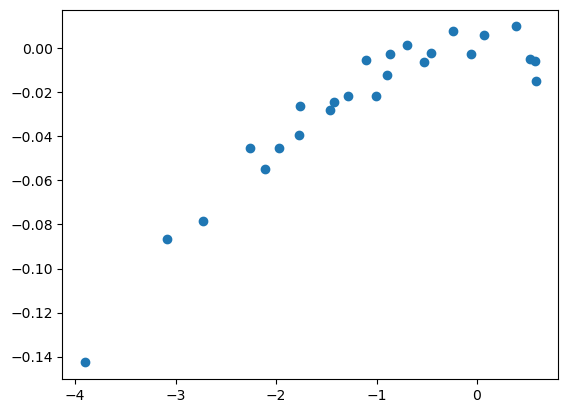

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(30)

x = np.random.normal(-1,1,size=25)
eps = np.random.normal(0,0.6,size=25)
x.sort()
y = -x**2/100+eps/100

plt.scatter(x,y)
plt.show()

Doing the random split into two parts in python usually uses `sklearn.model_selection.train_test_split`, which can split either a dataset or a pair of source $x$ and target $y$. Doing a split in three parts requires two calls to `train_test_split`, one to isolate the training set, and another to separate the validation and test sets. It looks like this:

In [28]:
from sklearn.model_selection import train_test_split
# Here we are creating the features to perform regression using up to
# fifth order polynomials.
x5 = np.array([x, x**2, x**3, x**4, x**5]).T

X_train, X_tv, y_train, y_tv = train_test_split(x5, y, test_size = 0.4)
X_validation, X_test, y_validation, y_test = train_test_split(X_tv, y_tv, test_size = 0.5)

And here's the random split, with three colors and shapes coding for the three sets.

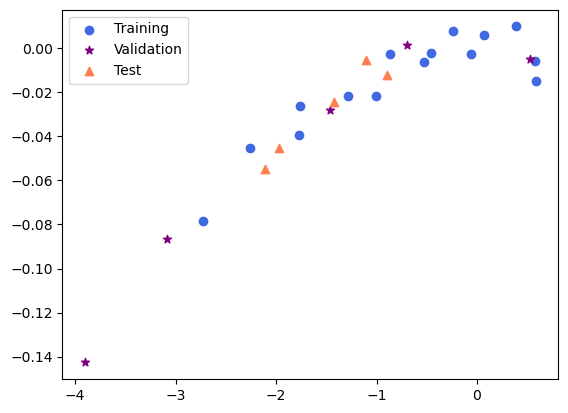

In [29]:
plt.scatter(X_train[:,0],y_train,color='royalblue',marker='o',label='Training')
plt.scatter(X_validation[:,0],y_validation,color='purple',marker='*',label='Validation')
plt.scatter(X_test[:,0],y_test,color='coral',marker='^',label='Test')
plt.legend()
plt.show()

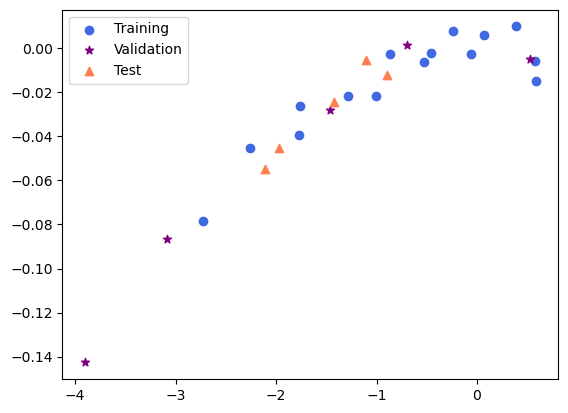

In [30]:
plt.scatter(X_train[:,0],y_train,color='royalblue',marker='o',label='Training')
plt.scatter(X_validation[:,0],y_validation,color='purple',marker='*',label='Validation')
plt.scatter(X_test[:,0],y_test,color='coral',marker='^',label='Test')
plt.legend()
plt.show()

In [31]:
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression()
lr2 = LinearRegression()
lr5 = LinearRegression()

lr1.fit(X_train[:,0].reshape(-1,1),y_train)
lr2.fit(X_train[:,0:2],y_train)
lr5.fit(X_train,y_train)

m1_score = lr1.score(X_validation[:,0].reshape(-1,1),y_validation)
m2_score = lr2.score(X_validation[:,0:2],y_validation)
m5_score = lr5.score(X_validation,y_validation)

print("m1_score: %.2f \t m2_score: %.2f \t m5_score: %.2f" % (m1_score,m2_score,m5_score))

m1_score: 0.65 	 m2_score: 0.97 	 m5_score: -0.84


We notice a big problem here with the fifth order model, it is overfitting badly, as the $R^2$ metric is negative. A negative value of $R^2$ means that the model is doing worse than simply using the average of the training set as an estimate for the whole validation set.

The final steps in the algorithm above are to choose the hypothesis `lr2` as our final model, and obtain a final test score for it:

In [33]:
m2_score = lr2.score(X_test[:,0:2],y_test)

print("final m2_score on test set: %.2f" % m2_score)

final m2_score on test set: 0.89


<div class="alert alert-info">
    
**Try:** rerun the split and training blocks and you will see the score values jump around, specifically the fifth order polynomial (high variance). This is a problem, since we want to be sure which model is better than the other, i.e. we want a more stable estimate of the generalization error of a model. 
    
</div>

### $k$-fold cross validation

One downside of the above method is firstly that it reduces the amount of training data to just $\sim 60\%$, but it also only tests the different models for **one** random split. A more stable way of selecting the model that generalizes best is to use $k$**-fold cross validation**. Let's start by looking at the following image:

<img src="k-fold-cross-validation.png" width=300>

Specifically we do:

1. Reserve some data for the final performance evaluation (test set). We therefore split the dataset $S$ into $S_\text{train}$ and $S_\text{test}$.
1. Randomly split the training data $S_\text{train}$ into $k$ equally sized and disjoint parts (also called folds), call them $S_1,\ldots,S_k$.
1. For each model $M_i$, we evaluate it as:
    * For $j = 1,\ldots, k$
        * Train the model $M_i$ on everything except $S_j$ to get the hypothesis $h_{ij}$ (i.e. the trained model). Compute the generalization error of $h_{ij}$ on $S_j$ and call it $\hat \epsilon_{ij}$. In the image below, we show two different permutations of the folds to get the training and validation data.
        
        <img src="k-fold.png" width=400>
    * Estimate the generalization error of the model $M_i$ by averaging the generalization error for each of the models $\hat \epsilon_{ij}$.
1. Choose the model with the lowest average generalization error. Retrain the model on the entire $S_\text{train}$ and use $S_\text{test}$ to make a final assessment of the model performance.

Common values for $k$ are generally in the $3$-$10$ interval, depending on a balance between computational time and amount of available data. If your data is really scarce then we can set $k=|S|$ i.e. we only hold one data point out at each fold, this is called **leave-one-out cross validation**.

#### Example
We continue with the above example and produce a simple `KFold` iterator, i.e. we construct a `KFold` object and iterate through the folds and compute a score for each. We are performing Step 3 above, but for only one model.

In [37]:
from sklearn.model_selection import KFold

In [39]:
kfold = KFold(n_splits=5,random_state=10,shuffle=True)
scores = []
for train_index, validation_index in kfold.split(x):
    # Each output gives indices for the training indexes and validation indexes
    lr = LinearRegression()
    
    # We use x5 which implies we are using the full fifth order polynomial
    lr.fit(x5[train_index], y[train_index])
    
    # We append the resulting score in the scores list, again here we use the built in R^2
    # score which implies that higher is better.
    scores.append(lr.score(x5[validation_index], y[validation_index]))

In [40]:
scores

[0.9507831270100051,
 -0.24406850489430632,
 0.9382695419255225,
 0.7081912676671038,
 -0.2822017221684001]

There is a convenience function for this, it is called `cross_val_score`, all we need to supply is the model, the data and the number of folds, in this case $5$ since we don't have that much data. Since we don't specify which scorer we will want to use, `cross_val_score` will return the value of `lr.score` which is the $R^2$ metric.

In [41]:
len(x5[:,0:5])

25

In [42]:
x_t = x5[:,1:2]

In [43]:
len(x_t)

25

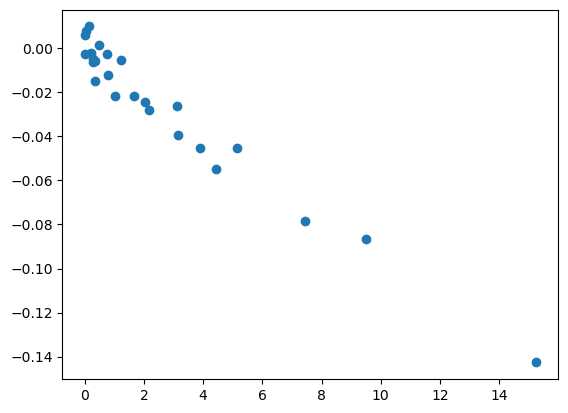

In [44]:
plt.scatter(x_t,y)
plt.show()

In [45]:
from sklearn.model_selection import cross_val_score

In [46]:
X = x5[:,0:1]

model = LinearRegression()
model.fit(X, y)

#lr.predict(x_t)

LinearRegression()

In [47]:
y_pred = model.predict(X)

In [48]:
from sklearn.metrics import r2_score

r2_score(y, y_pred)

0.7923224290957912

In [49]:
y

array([-0.14266144, -0.08655113, -0.07829724, -0.04534924, -0.05459119,
       -0.04543788, -0.03940681, -0.02625564, -0.02780362, -0.0243851 ,
       -0.02164539, -0.0054345 , -0.02164291, -0.01217401, -0.0023999 ,
        0.00145716, -0.00602432, -0.0023062 ,  0.00779018, -0.00242592,
        0.00607318,  0.0099199 , -0.00491594, -0.00566555, -0.0149872 ])

In [50]:
x_train_t = x5[0:20,0:1]
y_train_t = y[0:20]

x_test_t = x5[20:25,0:1]
y_test_t = y[20:25]

model = LinearRegression()
model.fit(x_train_t, y_train_t)
y_pred_t = model.predict(x_test_t)
r2_score(y_test_t, y_pred_t)

-20.087826326107525

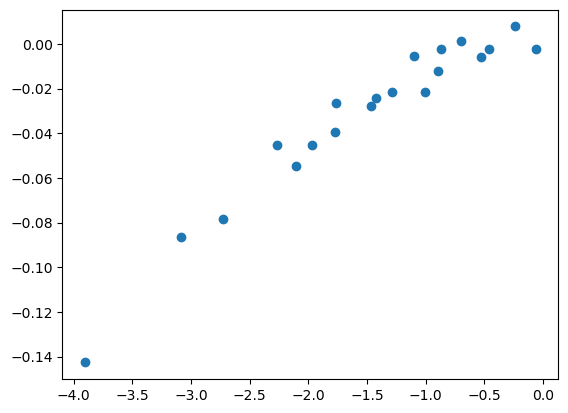

In [51]:
plt.scatter(x_train_t,y_train_t)
plt.show()

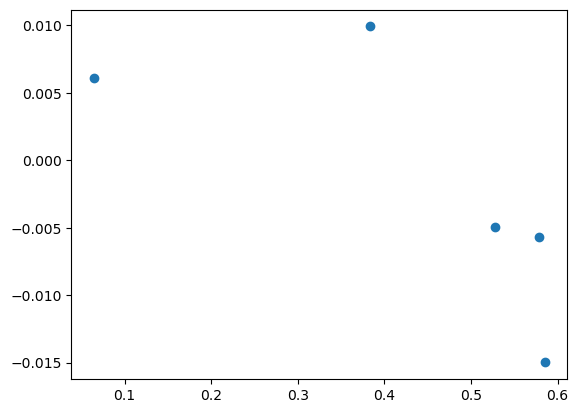

In [52]:
plt.scatter(x_test_t,y_test_t)
plt.show()

In [53]:
cv1 = cross_val_score(lr, x5[:,0:1], y, cv=5)
cv1

array([ -0.8882969 ,  -1.24142031,  -2.84114092,  -5.02314676,
       -20.08782633])

In [54]:
lr = LinearRegression()
cv1 = cross_val_score(lr, x5[:,0:1], y, cv=5)
cv2 = cross_val_score(lr, x5[:,0:2], y, cv=5)
cv5 = cross_val_score(lr, x5[:,0:5], y, cv=5)

In [55]:
print("Cross validation error cv1 = %.4f, cv2 = %.4f, cv5 = %.4f" % (np.mean(cv1), np.mean(cv2), np.mean(cv5)))
print("Cross validation variance cv1 = %.4f, cv2 = %.4f, cv5 = %.4f" % (np.std(cv1)**2, np.std(cv2)**2, np.std(cv5)**2))

Cross validation error cv1 = -6.0164, cv2 = -0.1600, cv5 = -88.1113
Cross validation variance cv1 = 51.6343, cv2 = 0.4238, cv5 = 30362.5234


Again we see that the second order equation is best, the first order equation is second best and the fifth order equation is worst. Adding more data this is likely to change and the fifth order and second order would probably be equally good. Why is this? Well basically with additional data we reduce the uncertainty about the coefficients for the third, fourth and fifth order terms.

Given candidate models of similar predictive or explanatory power, the simplest model is most likely to be the best choice ([Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor#Science_and_the_scientific_method)).

Let's redo the example with more data and this time take a larger number of folds to get a better estimate of our generalization error.

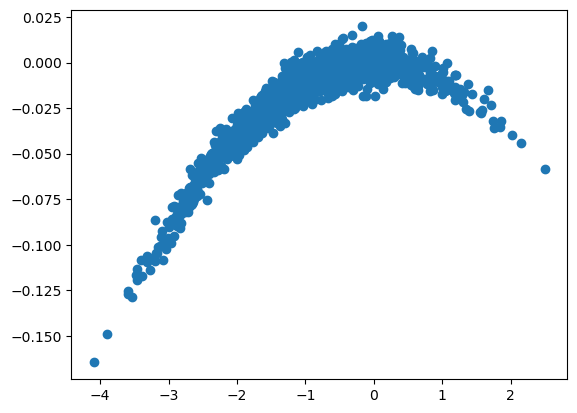

In [57]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(30)

x_new = np.random.normal(-1,1,size=1500)
eps_new = np.random.normal(0,0.6,size=1500)
x_new.sort()
y_new = -x_new**2/100+eps_new/100

plt.scatter(x_new,y_new)
plt.show()

In [58]:
x5_new = np.array([x_new, x_new**2, x_new**3, x_new**4, x_new**5]).T

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(x5_new, y_new, test_size = 0.3)

In [59]:
lr = LinearRegression()
cv1_new = cross_val_score(lr, x5_new[:,0:1], y_new, cv=10)
cv2_new = cross_val_score(lr, x5_new[:,0:2], y_new, cv=10)
cv5_new = cross_val_score(lr, x5_new[:,0:5], y_new, cv=10)

In [60]:
print("Cross validation error cv1 = %.4f, cv2 = %.4f, cv5 = %.4f" % (np.mean(cv1_new),np.mean(cv2_new),np.mean(cv5_new)))
print("Cross validation variance cv1 = %.4f, cv2 = %.4f, cv5 = %.4f" % (np.std(cv1_new)**2,np.std(cv2_new)**2,np.std(cv5_new)**2))

Cross validation error cv1 = -3.1348, cv2 = 0.2570, cv5 = 0.2396
Cross validation variance cv1 = 21.5571, cv2 = 0.1056, cv5 = 0.0920


As we can see, adding more data both reduces the variance but we also have that the second and fifth order are comparable in both bias and variance and using Occam's razor we choose the second order.

***
<center>Combient Mix AB All Rights Reserved</center>

***